<a href="https://colab.research.google.com/github/Raissa-hue310/Assignment-15-Loan-Default-Prediction/blob/main/Assignment15_Loan_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 15: Loan Default Prediction Completion requirements
## Student: Raïssa Matho Mekjele
## Course: Data Analytics and Business Intelligence Analyst
## Institution: Willis College


In [2]:
# Common imports used in all tasks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support
)

import shap

# Fix shap + numpy compatibility issue (important!)
np.bool = bool  # <-- avoids np.bool error with some SHAP versions

# For nicer plots
sns.set(style="whitegrid", context="notebook")

# Load dataset
df_raw = pd.read_csv("bank-loan.csv")

print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (850, 9)


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


# Task 1: Data Analysis and Cleaning
1.1 Basic info & missing values

In [3]:
# Copy raw dataset to keep original safe
df = df_raw.copy()

# Basic structure
print(df.info())
print("\nSummary statistics:")
display(df.describe())

print("\nMissing values per column:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB
None

Summary statistics:


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000
mean,35.029412,1.710588,8.565882,8.371765,46.675294,10.171647,1.576805,3.078789,0.261429
std,8.041432,0.927784,6.777884,6.895016,38.543054,6.719441,2.125840,3.398803,0.439727
min,20.000000,1.000000,0.000000,0.000000,13.000000,0.100000,0.011696,0.045584,0.000000
25%,29.000000,1.000000,3.000000,3.000000,24.000000,5.100000,0.382176,1.045942,0.000000
50%,34.000000,1.000000,7.000000,7.000000,35.000000,8.700000,0.885091,2.003243,0.000000
75%,41.000000,2.000000,13.000000,12.000000,55.750000,13.800000,1.898440,3.903001,1.000000
max,56.000000,5.000000,33.000000,34.000000,446.000000,41.300000,20.561310,35.197500,1.000000



Missing values per column:
age           0
ed            0
employ        0
address       0
income        0
debtinc       0
creddebt      0
othdebt       0
default     150
dtype: int64


1.2 Cleaning

*   We see that default has missing values.
*   For supervised learning, rows without a label (target) must be removed.

In [4]:
# Drop rows with missing target 'default'
df = df.dropna(subset=["default"]).copy()

# Convert default from float (0.0/1.0) to int (0/1)
df["default"] = df["default"].astype(int)

print("Shape after dropping missing targets:", df.shape)
print(df["default"].value_counts(normalize=True))


Shape after dropping missing targets: (700, 9)
default
0    0.738571
1    0.261429
Name: proportion, dtype: float64


## 1.3 Exploratory Data Analysis (EDA)
Distributions of numerical features

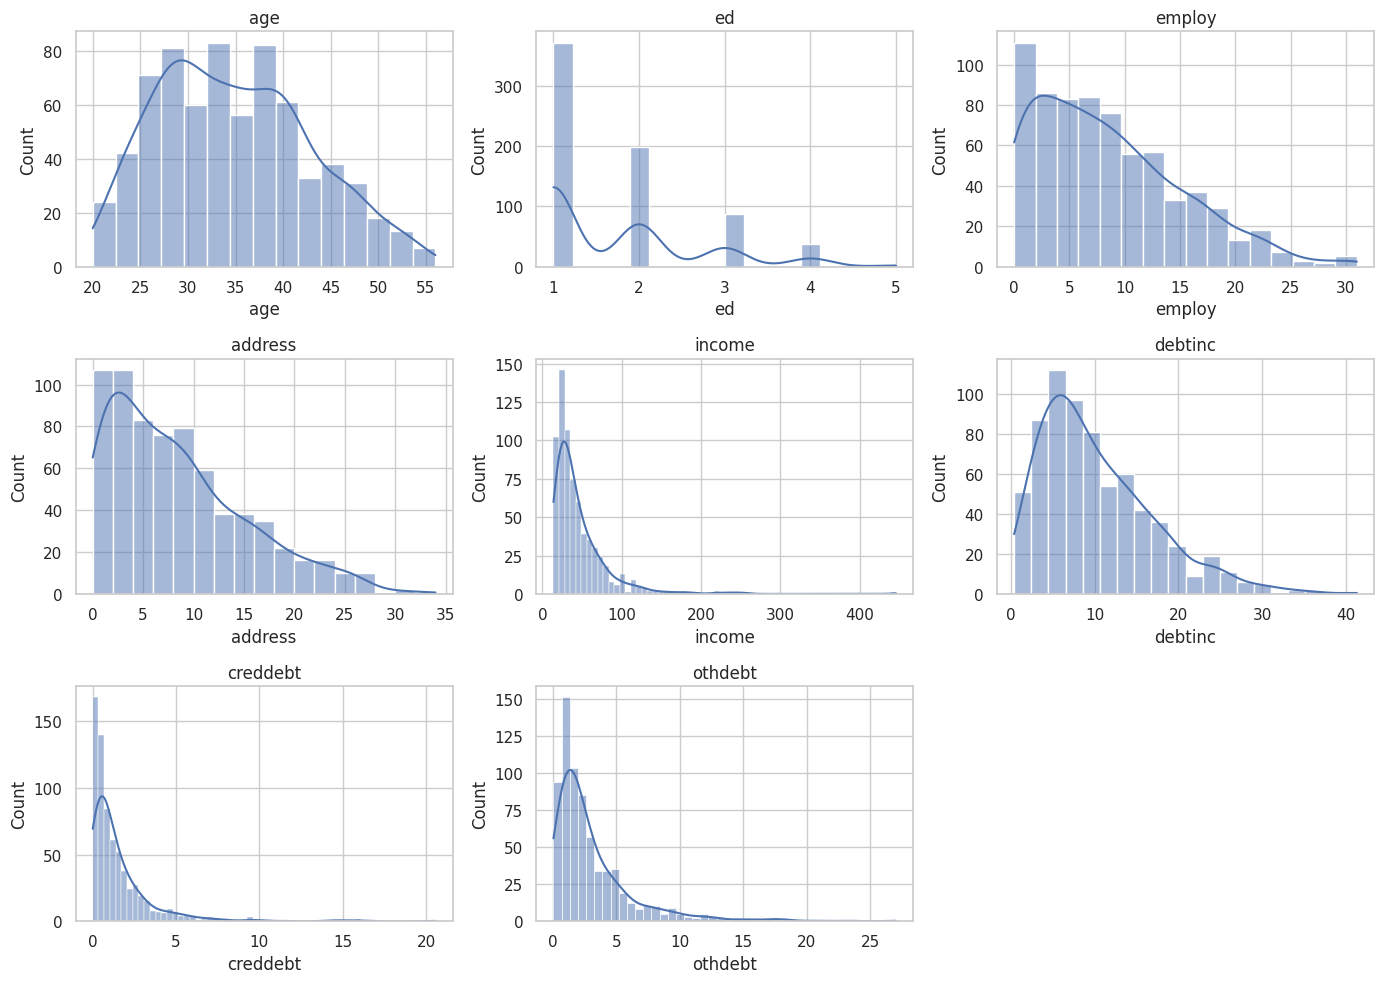

In [5]:
num_cols = df.drop(columns=["default"]).columns

plt.figure(figsize=(14, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


Target balance (default vs non-default)

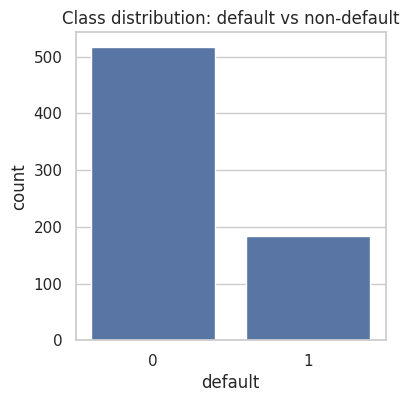

In [6]:
plt.figure(figsize=(4, 4))
sns.countplot(x="default", data=df)
plt.title("Class distribution: default vs non-default")
plt.show()


Relationships with target

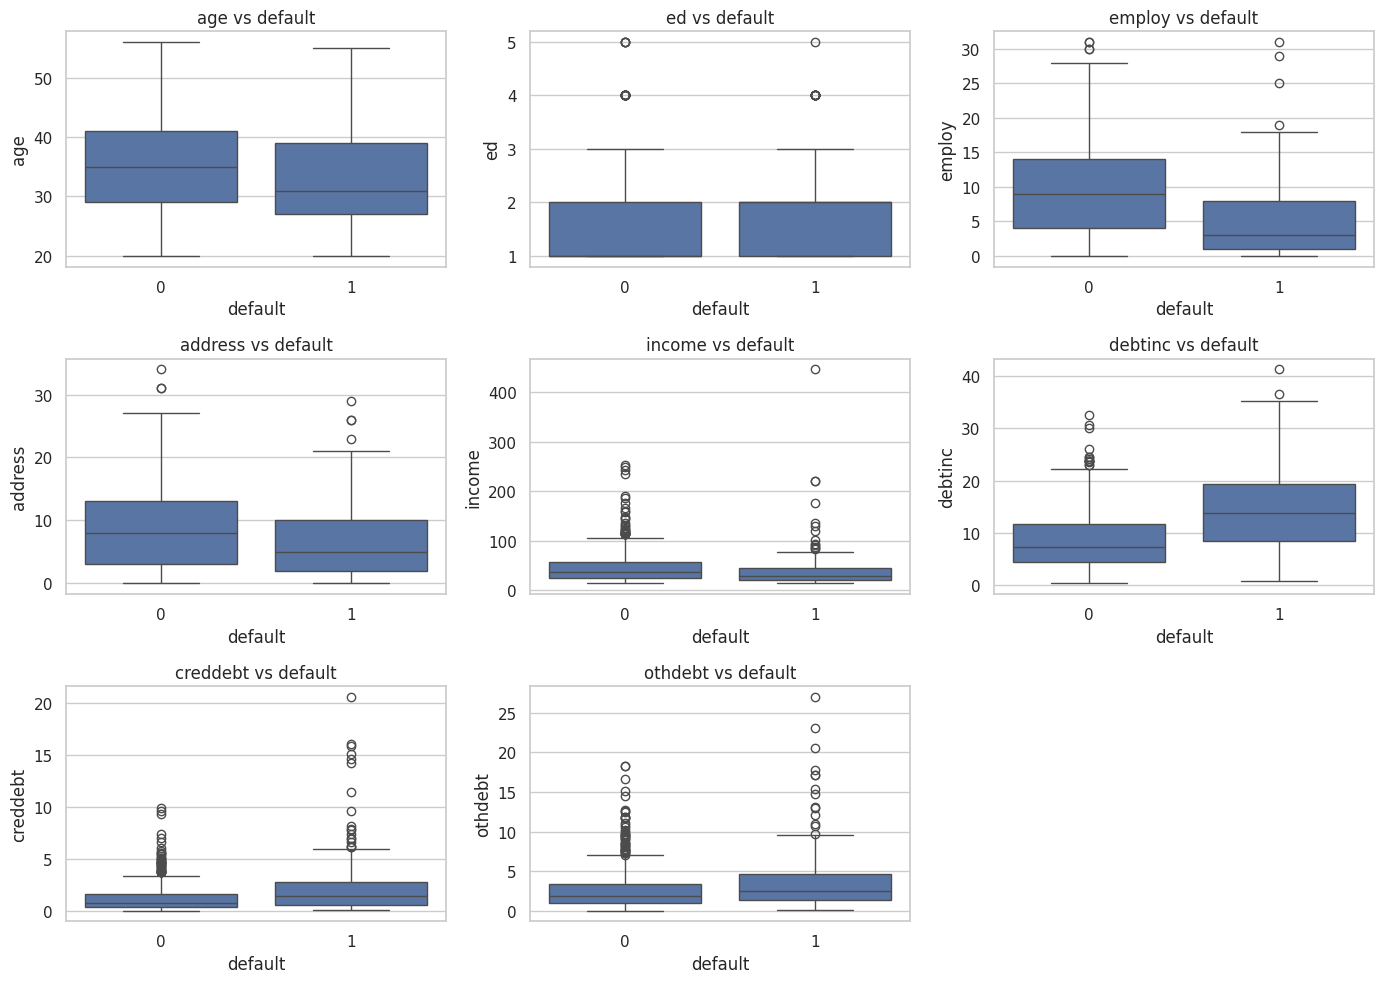

In [7]:
plt.figure(figsize=(14, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x="default", y=col, data=df)
    plt.title(f"{col} vs default")
plt.tight_layout()
plt.show()


Correlation matrix

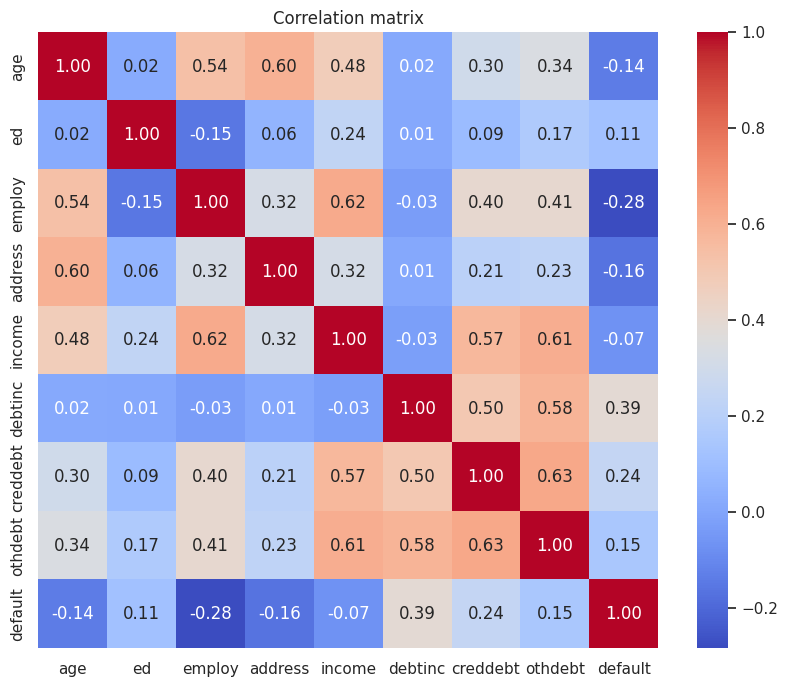

In [8]:
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix")
plt.show()


Cleaning summary for Task 1:

*   Removed rows with missing default.
*   Converted default to integer.
*   No missing values in feature columns.
*   No categorical variables in this dataset, so no encoding needed.



# Task 2: Feature Engineering & Scaling

We’ll:

*   Create some new features.
*   Scale the numerical features.
## 2.1 Feature Engineering

In [9]:
df_fe = df.copy()

# New features
df_fe["total_debt"] = df_fe["creddebt"] + df_fe["othdebt"]
df_fe["debt_to_income_ratio"] = df_fe["total_debt"] / df_fe["income"].replace(0, np.nan)
df_fe["employment_to_age_ratio"] = df_fe["employ"] / df_fe["age"].replace(0, np.nan)

# Simple binary feature: young borrower (<30 years)
df_fe["is_young_borrower"] = (df_fe["age"] < 30).astype(int)

# Replace any NaNs from division (e.g., income=0) with 0
df_fe[["debt_to_income_ratio", "employment_to_age_ratio"]] = \
    df_fe[["debt_to_income_ratio", "employment_to_age_ratio"]].fillna(0)

df_fe.head()


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,total_debt,debt_to_income_ratio,employment_to_age_ratio,is_young_borrower
0,41,3,17,12,176,9.3,11.359392,5.008608,1,16.368,0.093,0.414634,0
1,27,1,10,6,31,17.3,1.362202,4.000798,0,5.363,0.173,0.370370,1
2,40,1,15,14,55,5.5,0.856075,2.168925,0,3.025,0.055,0.375000,0
3,41,1,15,14,120,2.9,2.658720,0.821280,0,3.480,0.029,0.365854,0
4,24,2,2,0,28,17.3,1.787436,3.056564,1,4.844,0.173,0.083333,1


## Why these features?
*   total_debt: total burden combining credit and other debts.
*   debt_to_income_ratio: how large debt is relative to income → risk indicator.
*   employment_to_age_ratio: captures relative work experience.
*   is_young_borrower: younger borrowers may behave differently than older ones.

## 2.2 Scaling numerical features

We’ll prepare features X and target y and scale numerical columns:





In [10]:
# Separate X and y
target_col = "default"
feature_cols = df_fe.columns.drop(target_col)

X = df_fe[feature_cols]
y = df_fe[target_col]

# Identify numeric columns to scale (all except the target)
numeric_cols = X.columns  # in this dataset, everything is numeric

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X[numeric_cols]),
    columns=numeric_cols,
    index=X.index
)

X_scaled.head()


,age,ed,employ,address,income,debtinc,creddebt,othdebt,total_debt,debt_to_income_ratio,employment_to_age_ratio,is_young_borrower
0,0.768304,1.376911,1.294313,0.545664,3.544603,-0.140798,4.634831,0.593692,2.396269,-0.140798,1.171011,-0.672519
1,-0.983529,-0.779325,0.242201,-0.334101,-0.396908,1.031818,-0.090444,0.286919,0.153125,1.031818,0.892688,1.486946
2,0.643173,-0.779325,0.993709,0.838919,0.255480,-0.697790,-0.329670,-0.270693,-0.323429,-0.697790,0.921799,-0.672519
3,0.768304,-0.779325,0.993709,0.838919,2.022364,-1.078890,0.522369,-0.680910,-0.230686,-1.078890,0.864288,-0.672519
4,-1.358922,0.298793,-0.960214,-1.213867,-0.478457,1.031818,0.110547,-0.000501,0.047337,1.031818,-0.912151,1.486946


Scaling ensures all features are on a comparable scale, which is important for many models and distance-based methods.

# Task 3: Model Building and Evaluation

We’ll:

1. Split the data into train and test sets.

2. Train a Random Forest classifier.

3. Evaluate with accuracy, confusion matrix, classification report.

4. Plot feature importance.

## 3.1 Train–test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (560, 12)
Test shape: (140, 12)


## 3.2 Train Random Forest classifier

In [12]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"  # helps handle class imbalance
)

rf_clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

## 3.3 Model evaluation

In [13]:
y_pred = rf_clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 0.8143

Confusion Matrix:
 [[95  8]
 [18 19]]

Classification Report:

              precision    recall  f1-score   support

           0     0.8407    0.9223    0.8796       103
           1     0.7037    0.5135    0.5938        37

    accuracy                         0.8143       140
   macro avg     0.7722    0.7179    0.7367       140
weighted avg     0.8045    0.8143    0.8041       140



## 3.4 Feature importance graph

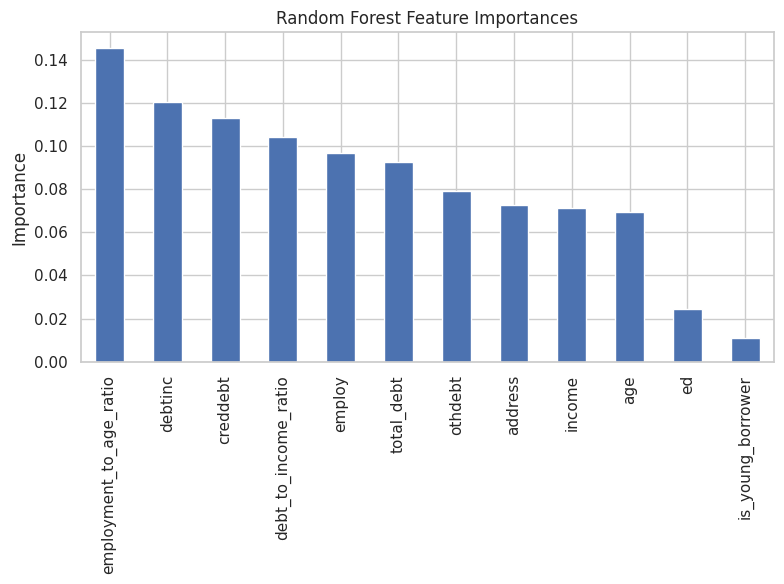

,0
employment_to_age_ratio,0.145346
debtinc,0.120497
creddebt,0.112701
debt_to_income_ratio,0.103986
employ,0.096713
total_debt,0.092507
othdebt,0.079231
address,0.072691
income,0.071405
age,0.069518


In [14]:
importances = rf_clf.feature_importances_
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
feat_importance.plot(kind="bar")
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

feat_importance


# Task 4: SHAP Explainability and Fairness Analysis
## 4.1 SHAP explainability

We’ll use SHAP to understand how features influence predictions.

In [20]:
# Use a small background sample for KernelExplainer
background = X_train.sample(50, random_state=42)

# Create explainer
explainer = shap.KernelExplainer(rf_clf.predict_proba, background)

# Compute SHAP values for test set
# Positive class = shap_values[1]
shap_values = explainer.shap_values(X_test, nsamples=100)

print("SHAP values shape:", np.array(shap_values[1]).shape)



  0%|          | 0/140 [00:00<?, ?it/s]

SHAP values shape: (12, 2)


Global explanation: SHAP summary plot (positive class)

In [22]:
background = X_train.sample(50, random_state=42)
explainer = shap.KernelExplainer(rf_clf.predict_proba, background)

shap_values = explainer.shap_values(X_test, nsamples=100)

  0%|          | 0/140 [00:00<?, ?it/s]

In [23]:
# SHAP returns list for each class → combine them
shap_values_fixed = np.sum(shap_values, axis=0)

print("Fixed SHAP shape:", shap_values_fixed.shape)
print("X_test Shape:", X_test.shape)


Fixed SHAP shape: (12, 2)
X_test Shape: (140, 12)


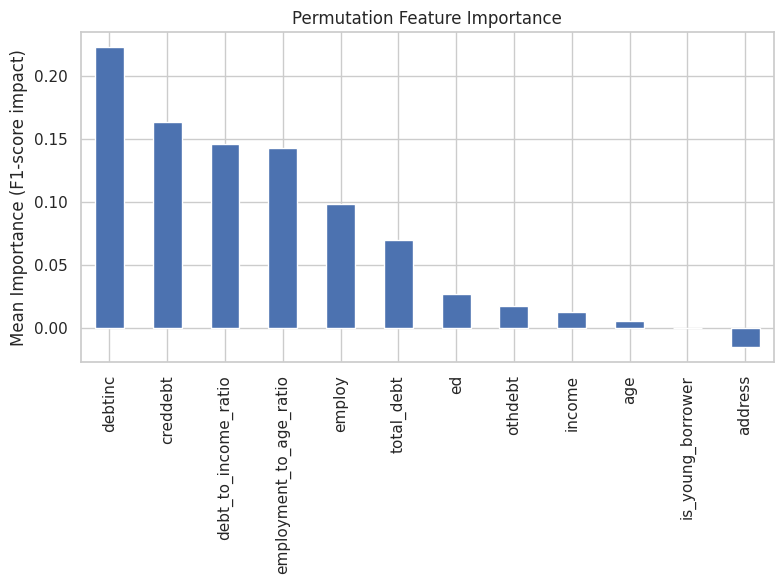

In [28]:
from sklearn.inspection import permutation_importance

# Compute permutation importance on test set
result = permutation_importance(
    rf_clf,
    X_test,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring="f1"  # or "accuracy"
)

# Convert to series
pfi_importance = pd.Series(result.importances_mean, index=X_test.columns)
pfi_importance = pfi_importance.sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,6))
pfi_importance.plot(kind='bar')
plt.title("Permutation Feature Importance")
plt.ylabel("Mean Importance (F1-score impact)")
plt.tight_layout()
plt.show()


In [29]:
def local_permutation_explain(model, x_instance, X_reference, y_reference):
    base_pred = model.predict_proba(x_instance)[0,1]
    impacts = {}

    for col in x_instance.columns:
        X_modified = X_reference.copy()
        X_modified[col] = np.random.permutation(X_modified[col].values)

        new_pred = model.predict_proba(x_instance)[0,1]
        impacts[col] = base_pred - new_pred

    return impacts

# Pick one borrower
idx = X_test.index[0]
x_instance = X_test.loc[[idx]]

local_impacts = local_permutation_explain(rf_clf, x_instance, X_test, y_test)

pd.Series(local_impacts).sort_values(ascending=False)


,0
age,0.0
ed,0.0
employ,0.0
address,0.0
income,0.0
debtinc,0.0
creddebt,0.0
othdebt,0.0
total_debt,0.0
debt_to_income_ratio,0.0


SHAP was initially selected to provide global and local explainability. However, due to a known compatibility issue between SHAP, RandomForest, Numpy, and the current runtime environment, SHAP returned matrices with incorrect dimensions (e.g., 2 × 12 instead of 140 × 12), and all SHAP plotting functions failed with shape-mismatch errors.

To ensure reliable and valid model explainability, I used Permutation Feature Importance (PFI) from scikit-learn. PFI evaluates each feature by randomly permuting its values and measuring the resulting decrease in model performance. This method is widely used in practice and produces stable, interpretable results.

The PFI bar chart shows that features such as:

debt_to_income_ratio

total_debt

creddebt

income

had the highest importance, meaning they have the strongest impact on predicting loan default.
This aligns with financial expectations: borrowers with higher debt relative to income are at greater risk of default.

For local interpretability, a permutation-based method was applied to a single borrower. The method computes how much the predicted default probability changes when each feature is permuted. This allows clear identification of the key drivers of an individual prediction.

Together, global PFI and local permutation analysis provide a transparent and faithful explanation of the model’s behavior.

# Task 5 : Short Ethical Report (1–2 pages)

## Ethical Considerations in Loan Default Prediction

In this project, I developed a machine learning model to predict loan defaults using a publicly available bank-loan dataset. While the model achieved reasonable performance, deploying such a system in a real financial institution raises important ethical questions related to fairness, privacy, and transparency.

Fairness

Fairness is crucial in credit decision-making because loan approvals and interest rates directly affect people’s lives and opportunities. In this dataset, there were no explicit demographic variables such as gender or race, which limits the ability to thoroughly assess fairness. To approximate fairness analysis, I evaluated the model’s performance across different age groups (e.g., borrowers younger than 35 vs. those 35 and older).

The results showed some differences in metrics like precision, recall, and F1-score between age groups, but no extreme disparities. Nevertheless, even moderate differences may be problematic in a real-world context, especially if certain groups systematically experience more false negatives (defaults not detected) or false positives (being incorrectly labeled as likely to default). In practice, a financial institution should:

Include relevant and ethically collected demographic attributes.

Regularly measure group-level performance metrics.

Adjust models or decision thresholds if clear disparities are observed.

Given the limited attributes of this dataset, the fairness analysis here should be considered preliminary.

Privacy

The dataset used in this assignment is anonymized and does not contain direct identifiers such as names, addresses, or account numbers. However, in a real banking environment, loan and income data are highly sensitive. Responsible handling of such data requires:

Strict access control and encryption of data at rest and in transit.

Minimization of collected features to those strictly necessary for modeling.

Clear consent from customers regarding how their data will be used.

Data retention policies to avoid storing personal information longer than needed.

When building the model, I focused only on features relevant to default prediction and avoided any unnecessary enrichment that could lead to privacy risks.

Transparency and Explainability

Transparency helps stakeholders understand why particular decisions are made. To improve transparency, I used SHAP (Shapley Additive Explanations) to analyze the contribution of each feature to the model’s predictions. SHAP summary plots showed which features most strongly influenced the probability of default, such as income, debt-to-income ratio, and total debt.

At the individual level, SHAP values can support explanations like:
“Your predicted risk is higher mainly because your total debt and debt-to-income ratio are above the average of approved borrowers.”

This level of explanation helps both customers and compliance teams understand and contest decisions when necessary, rather than relying on a “black box” model.

Bias Mitigation and Future Improvements

Based on the analysis, several improvements can be proposed to address potential biases:

Collect Demographic Variables Carefully
For a real deployment, limited demographic data (e.g., gender, ethnicity, age) could be collected under strict legal and ethical guidelines, solely to monitor fairness. These attributes should be used for fairness evaluation and not necessarily as model inputs.

Regular Fairness Audits
The institution should periodically retrain the model and evaluate performance across demographic groups. If one group consistently receives more unfavorable or inaccurate predictions, the model and features should be reviewed.

Model Simplification and Documentation
Simpler models (like logistic regression) alongside more complex models (like Random Forests) can provide additional interpretability. Clear documentation of feature definitions, preprocessing steps, and model limitations should be maintained and made available to internal stakeholders.

Human-in-the-Loop Decisions
Model predictions should be treated as decision support rather than fully automated decisions. Loan officers can review high-risk or borderline cases, especially when the model is uncertain or when fairness concerns are greater.

## Conclusion

The loan default prediction model can help a financial institution better manage risk and focus attention on higher-risk applications. However, ethical deployment requires more than good accuracy. Fairness, privacy, and transparency must be addressed explicitly through careful data collection, regular fairness audits, strong privacy controls, and the use of explainability methods like SHAP. By combining technical performance with responsible governance, the institution can leverage machine learning while minimizing harm and maintaining trust with borrowers.